# Pigpen PyTorch Example
by Joe Norton

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [42]:
import random
import os
from PIL import Image
from torch.utils.data import Dataset

class PigpenDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA']
        self.images = []
        for cls in self.classes:
            cls_dir = os.path.join(directory, cls)
            self.images += [(os.path.join(cls_dir, img), cls) for img in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, img))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, cls = self.images[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, self.classes.index(cls)


In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Example normalization
])

train_dataset = PigpenDataset('train', transform=transform)
test_dataset = PigpenDataset('test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [44]:
len(train_dataset), len(test_dataset)

(27000, 13527)

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)  # Adjust the size according to your architecture
        self.fc2 = nn.Linear(128, 28)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [46]:

# Create the network, define a loss function, and optimizer
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Train the network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 2.142
[1,   200] loss: 0.198
[1,   300] loss: 0.051
[1,   400] loss: 0.021
[1,   500] loss: 0.009
[1,   600] loss: 0.005
[1,   700] loss: 0.005
[1,   800] loss: 0.007
[2,   100] loss: 0.002
[2,   200] loss: 0.001
[2,   300] loss: 0.000
[2,   400] loss: 0.001
[2,   500] loss: 0.000
[2,   600] loss: 0.001
[2,   700] loss: 0.003
[2,   800] loss: 0.003
Finished Training


In [47]:
# Test the network on the test data
correct = 0
total = 0
misclassified_images = []
misclassified_labels = []
num_classes = 27  # Replace 'classes' with your classes
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        misclassified = (predicted != labels)
        
        for i in range(images.size(0)):
            if misclassified[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])
    
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')
# Convert lists to tensors
misclassified_images = torch.stack(misclassified_images)
misclassified_labels = torch.tensor(misclassified_labels)

Accuracy of the network on the 13527 test images: 74 %


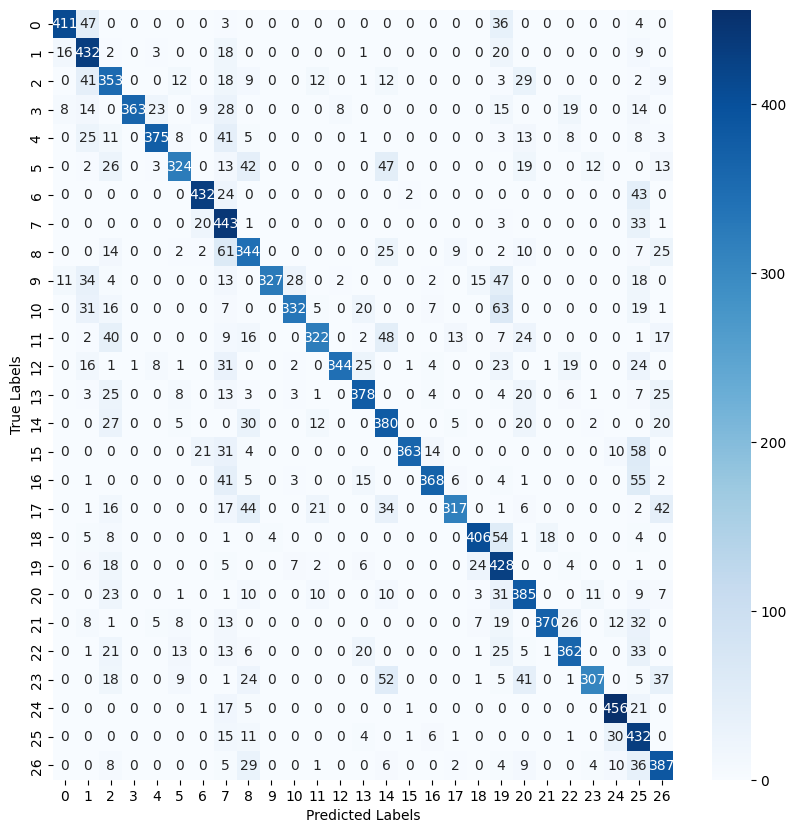

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Convert to numpy array for visualization
conf_matrix_np = conf_matrix.numpy()
# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [49]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

True Label: 0, Predicted Label: 8


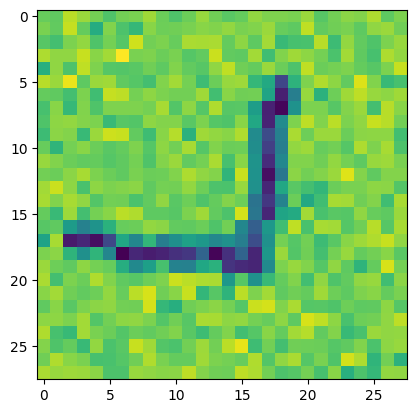

True Label: 0, Predicted Label: 26


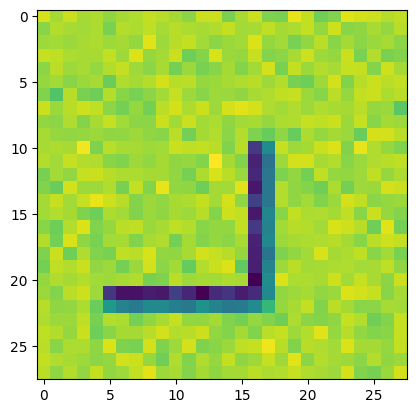

True Label: 0, Predicted Label: 26


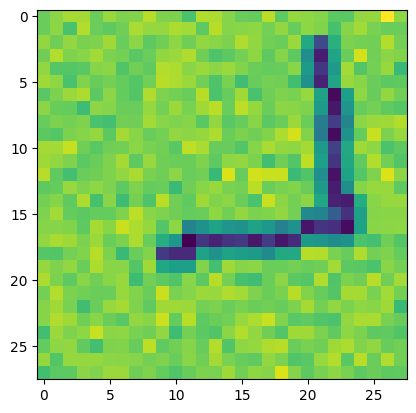

True Label: 0, Predicted Label: 26


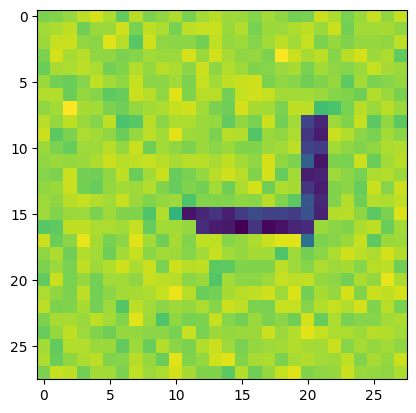

True Label: 0, Predicted Label: 26


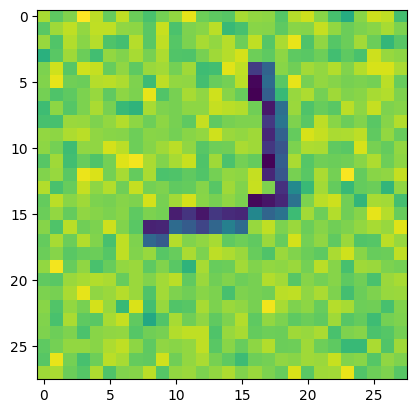

In [50]:
# Display first few misclassified images
num_images_to_show = 5  # You can change this number as needed
for i in range(min(num_images_to_show, len(misclassified_images))):
    print(f"True Label: {misclassified_labels[i].item()}, Predicted Label: {predicted[i]}")
    imshow(misclassified_images[i])